## Plotting Time Series Data from NetCDF

In this example we show how to programatically download and work with OOI NetCDF time series data. We will use data from the Global Argentine Basin Flanking Subsurface Mooring A Mooring Riser CTD at 30 m. You will learn:

* how to find the data you are looking for
* how to use the machine to machine API to request data
* how to load the NetCDF data into your notebook, once the data request has completed
* how to plot data

For the instrument in this example, you will need the Reference Designator, Stream and Data Delivery Method to make the request to the M2M API. More information about the instrument can be found here:
http://ooi.visualocean.net/instruments/view/GA03FLMA-RIM01-02-CTDMOG040

![GA03FLMA-RIM01-02-CTDMOG040](../../../../images/GA03FLMA-RIM01-02-CTDMOG040.png)

In [1]:
import requests
import time

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner), or use the credentials provided below.

In [2]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

Specify your inputs.

In [3]:
subsite = 'GA03FLMA'
node = 'RIM01'
sensor = '02-CTDMOG040'
method = 'recovered_inst'
stream = 'ctdmo_ghqr_instrument_recovered'
beginDT = '2015-03-17T01:01:01.500Z' # this time range encompasses all three deployments of this instrument.
endDT = '2018-09-01T01:01:01.500Z'

Build the GET request URL and send the request to the M2M API endpoint.

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [5]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180430T162903-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

Check if the request has completed.

In [6]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 959 ms, sys: 68.6 ms, total: 1.03 s
Wall time: 1min


In [7]:
import re
import xarray as xr
import pandas as pd
import os

Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

In [8]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180430T162903-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0003_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20161030T233001-20180109T120001.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180430T162903-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0002_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20151125T193001-20161105T184501.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180430T162903-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0001_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20150317T194501-20151122T120001.nc']

Load all files into a single xarray dataset.

In [9]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                      (time: 98995)
Coordinates:
    obs                          (time) int64 dask.array<shape=(98995,), chunksize=(98995,)>
  * time                         (time) datetime64[ns] 2015-03-17T19:45:01 ...
    pressure                     (time) float64 dask.array<shape=(98995,), chunksize=(98995,)>
    lat                          (time) float64 dask.array<shape=(98995,), chunksize=(98995,)>
    lon                          (time) float64 dask.array<shape=(98995,), chunksize=(98995,)>
Data variables:
    deployment                   (time) int32 dask.array<shape=(98995,), chunksize=(98995,)>
    id                           (time) |S64 dask.array<shape=(98995,), chunksize=(98995,)>
    conductivity                 (time) float64 dask.array<shape=(98995,), chunksize=(98995,)>
    ctd_time                     (time) datetime64[ns] dask.array<shape=(98995,), chunksize=(98995,)>
    driver_timestamp             (time) datetime64[ns] dask.array<sh

Plot the dataset using matplotlib, working under the hood of xarray.

In [10]:
import matplotlib.pyplot as plt

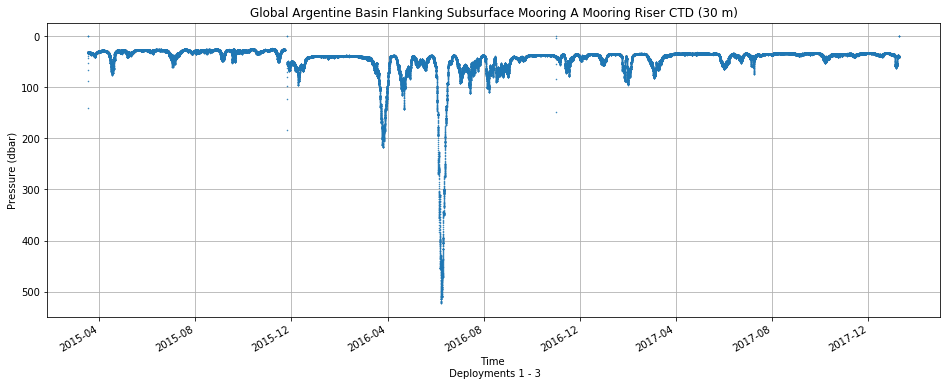

In [11]:
fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['ctdmo_seawater_pressure'].plot(linestyle = 'None', 
                                   marker='.', 
                                   markersize=1,
                                   ax=ax)

ax.invert_yaxis()
ax.grid()

plt.title('Global Argentine Basin Flanking Subsurface Mooring A Mooring Riser CTD (30 m)')
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time \n Deployments 1 - 3')
plt.show()

This CTD is supposed to be stationary at around 30 m depth in the water column, but violent storms in the southern himisphere can draw the CTD mooring chain down by hundreds of meters. More information about the Flanking Subsurface Mooring A can be found [here](http://oceanobservatories.org/site/ga03flma/).